# Stallion Dataset (Kaggle)

The dataset contains 21,000 rows, 350 different time series of length 60. Sales start at different points in time. The column containing the actuals is named `volume`. 

For the temporal fusion transformer - the model that allows exogenous variables to be included - features are generated. (Note that the code is taken from the [pytorch_forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html) website that does not calculate the features leakage free for cross validation. However, it is kept as is from the original tutorial.)

A 10-fold rolling window cross validation is performed. The forecast horizon in each cross validation run is chosen to be 6 periods long. 

## Import of Data

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


from pytorch_forecasting.data.examples import get_stallion_data

from statsmodels.tsa.forecasting.theta import ThetaModel
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster

from tqdm import tqdm

from pytorch_forecasting import NBeats
from pytorch_forecasting.data import NaNLabelEncoder

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")

data.sort_values(['timeseries', 'time_idx'])

agency     sku   volume       date  industry_volume  soda_volume  \
0      Agency_22  SKU_01   52.272 2013-01-01        492612703    718394219   
7096   Agency_22  SKU_01   62.532 2013-02-01        431937346    753938444   
8898   Agency_22  SKU_01   74.196 2013-03-01        509281531    892192092   
10733  Agency_22  SKU_01   89.424 2013-04-01        532390389    838099501   
12472  Agency_22  SKU_01   79.164 2013-05-01        551755254    864420003   
...          ...     ...      ...        ...              ...          ...   
18972  Agency_42  SKU_02  170.424 2017-08-01        623319783   1049868815   
20703  Agency_42  SKU_02  168.480 2017-09-01        604571152    984438234   
3384   Agency_42  SKU_02  146.880 2017-10-01        616747012    996763883   
5089   Agency_42  SKU_02  115.236 2017-11-01        592195062    967899589   
6744   Agency_42  SKU_02  147.636 2017-12-01        618073219    919709619   

       avg_max_temp  price_regular  price_actual    discount  ...  \
0         25.845238    1168.903668   1069.166193   99.737475  ...   
7096      29.313095    1169.357513   1069.465566   99.891947  ...   
8898      29.422353    1204.673581   1102.337519  102.336062  ...   
10733     32.433721    1235.187500   1129.538874  105.648626  ...   
12472     32.157647    1247.061989   1140.811136  106.250853  ...   
...             ...            ...           ...         ...  ...   
18972     35.780233    1686.687500   1381.632921  305.054579  ...   
20703     33.998837    1686.687500   1240.806330  445.881170  ...   
3384      32.786047    1686.687500   1251.362459  435.325041  ...   
5089      31.856977    1686.687500   1325.162372  361.525128  ...   
6744      24.315300    1713.806693   1412.828639  300.978054  ...   

       football_gold_cup  beer_capital  music_fest discount_in_percent  \
0                      -             -           -            8.532566   
7096                   -             -           -            8.542464   
8898                   -             -  music_fest            8.494920   
10733                  -             -           -            8.553246   
12472                  -             -           -            8.520094   
...                  ...           ...         ...                 ...   
18972                  -             -           -           18.086016   
20703                  -             -           -           26.435316   
3384                   -             -           -           25.809466   
5089                   -  beer_capital           -           21.434031   
6744                   -             -           -           17.561960   

      timeseries time_idx month log_volume avg_volume_by_sku  \
0              0        0     1   3.956461       2613.377501   
7096           0        1     2   4.135678       2916.978087   
8898           0        2     3   4.306710       3215.061952   
10733          0        3     4   4.493389       3515.822697   
12472          0        4     5   4.371522       3688.107793   
...          ...      ...   ...        ...               ...   
18972        349       55     8   5.138289       2761.568423   
20703        349       56     9   5.126817       2622.688673   
3384         349       57    10   4.989616       2802.116077   
5089         349       58    11   4.746982       1848.276721   
6744         349       59    12   4.994750       2267.730115   

      avg_volume_by_agency  
0                103.80546  
7096             121.04766  
8898             153.84672  
10733            163.15866  
12472            152.62596  
...                    ...  
18972            586.96503  
20703            611.63367  
3384             469.85904  
5089             487.62519  
6744             635.66895  

[21000 rows x 31 columns]

## Time series models

In [2]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

CV = 10 #number of CV runs, ie rolling time windows
results = []
for cv in tqdm(range(CV-1,-1,-1)):
    training_cutoff = data["time_idx"].max() - max_prediction_length - cv
    
    train_for_local_models = data.loc[data['time_idx'] <= training_cutoff].copy()
    test_for_local_models = data.loc[data['time_idx'] > training_cutoff].copy()

    timeseries_idx = sorted(test_for_local_models.timeseries.unique())

    fh = ForecastingHorizon(
        pd.PeriodIndex(pd.date_range(test_for_local_models.date.min() + pd.DateOffset(months=0), periods=6, freq="M"))
        , is_relative=False)

    for idx in timeseries_idx: 
        train_time_series = train_for_local_models.loc[train_for_local_models['timeseries'] == idx, 
                                                   ['date','volume']].set_index('date').squeeze()
        test_time_series = test_for_local_models.loc[test_for_local_models['timeseries'] == idx,
                                                         ['date','volume']].reset_index(drop = True).head(
                                                                                    max_prediction_length)
        train_time_series.index = pd.PeriodIndex(pd.date_range("2013-01", periods=len(train_time_series), freq="M"))
        
        #Sktime seasonal naive
        df_snaive = test_time_series.copy()
        df_snaive['Model'] = 'Seasonal Naive'
        df_snaive['CV'] = cv
        df_snaive['timeseries_idx'] = idx
        naive = NaiveForecaster(strategy = "last", sp = 12)
        naive.fit(train_time_series)
        df_snaive['Forecast'] = naive.predict(fh = fh).reset_index(drop = True)
        df_snaive['Replaced'] = 'Yes'
        results.append(df_snaive)
            
        #Statsmodels Theta
        df_theta = test_time_series.copy()
        df_theta['Model'] = 'Theta'
        df_theta['CV'] = cv
        df_theta['timeseries_idx'] = idx
        try:
            tm = ThetaModel(train_time_series, period = 12)
            tm_fitted = tm.fit()
            df_theta['Forecast'] = tm_fitted.forecast(6).reset_index(drop = True)
            df_theta['Replaced'] = 'No'
            results.append(df_theta)
        except ValueError:
            naive = NaiveForecaster(strategy = "mean")
            naive.fit(train_time_series)
            df_theta['Forecast'] = naive.predict(fh = fh).reset_index(drop = True)
            df_theta['Replaced'] = 'Yes'
            results.append(df_theta)

        #Sktime Auto ARIMA
        df_arima = test_time_series.copy()
        df_arima['Model'] = 'AutoArima'
        df_arima['CV'] = cv
        df_arima['timeseries_idx'] = idx
        try:
            arima = AutoARIMA(sp=12, n_jobs=-1, max_d=2, max_p=2, max_q=2, suppress_warnings=True)
            arima_fitted = arima.fit(train_time_series)
            df_arima['Forecast'] = arima_fitted.predict(fh).reset_index(drop = True)
            df_arima['Replaced'] = 'No'
            results.append(df_arima)
        except ValueError:    
            naive = NaiveForecaster(strategy = "mean")
            naive.fit(train_time_series)
            df_arima['Forecast'] = naive.predict(fh = fh).reset_index(drop = True)
            df_arima['Replaced'] = 'Yes'
            results.append(df_arima)
        
        #Sktime Auto ETS
        df_ets = test_time_series.copy()
        df_ets['Model'] = 'AutoETS'
        df_ets['CV'] = cv
        df_ets['timeseries_idx'] = idx
        try:
            autoets = AutoETS(auto=True, additive_only = True, n_jobs=-1, sp=12)
            autoets_fitted = autoets.fit(train_time_series)
            df_ets['Forecast'] = autoets_fitted.predict(fh).reset_index(drop = True)
            df_ets['Replaced'] = 'No'
            results.append(df_ets)
        except ValueError:    
            naive = NaiveForecaster(strategy = "mean")
            naive.fit(train_time_series)
            df_ets['Forecast'] = naive.predict(fh = fh).reset_index(drop = True)
            df_ets['Replaced'] = 'Yes'
            results.append(df_ets)

df_results_local1 = pd.concat(results) 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 10%|███████▋                                                                     | 1/10 [1:03:31<9:31:46, 3811.81s/it]

C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 20%|███████████████▍                                                             | 2/10 [2:00:03<7:55:19, 3564.97s/it]

C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 30%|███████████████████████                                                      | 3/10 [2:46:06<6:13:09, 3198.52s/it]

C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 40%|██████████████████████████████▊                                              | 4/10 [3:48:11<5:40:37, 3406.27s/it]

C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 50%|██████████████████████████████████████▌                                      | 5/10 [4:52:58<4:58:19, 3579.89s/it]

C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 60%|██████████████████████████████████████████████▏                              | 6/10 [6:01:10<4:10:15, 3753.83s/it]

 70%|█████████████████████████████████████████████████████▉                       | 7/10 [7:08:26<3:12:18, 3846.23s/it]

 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [8:18:17<2:11:52, 3956.01s/it]

 90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [9:30:13<1:07:48, 4068.52s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [10:18:04<00:00, 3698.62s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [10:18:04<00:00, 3708.42s/it]

The plots show actuals of an example time series (id 0) and forecasts by the Theta model, AutoArima and AutoETS. The forecasts  are generated by the 10-fold rolling window cross validation.

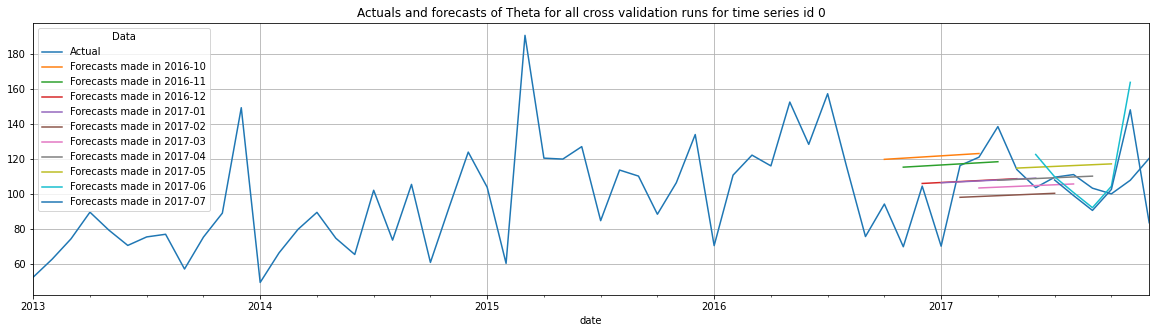

In [3]:
def generate_plot(df, raw_data, id, model):
  '''
  The function plots the historical actuals and the forecasts of all 
  cross validation runs. 
  
  Parameters: 
  id: int that selects one of the time series in the Stallion dataset
  model: str. One of ['Theta', 'AutoETS', 'AutoARIMA']
  '''
  forecasts = df.loc[(df['timeseries_idx'] == id) & (df['Model'] == model),['date','Forecast','CV']]
  forecasts['date'] = pd.to_datetime(forecasts['date'], errors='coerce').dt.to_period('M')
  forecasts['Data'] = 'Forecasts made in ' + forecasts.groupby('CV')['date'].transform('min').dt.strftime('%Y-%m')
  forecasts = forecasts.rename(columns = {'Forecast':'value'})
  
  actuals = raw_data.loc[(data['timeseries'] == id),['date','volume']].rename(columns = {'volume':'value'})
  actuals['Data'] = "Actual"
  actuals['date'] =  actuals['date'].dt.to_period('M')
  
  total = pd.concat([forecasts[['date','value', 'Data']].set_index('date'),
              actuals.set_index('date')],axis = 0).reset_index().pivot(index='date',
                                                                       columns = "Data", values = 'value')
  
  total.plot(figsize = (20,5), grid=True, title = "Actuals and forecasts of " + model + " for all cross validation runs for time series id " + str(id))

generate_plot(df_results_local1, data, 0, 'Theta')

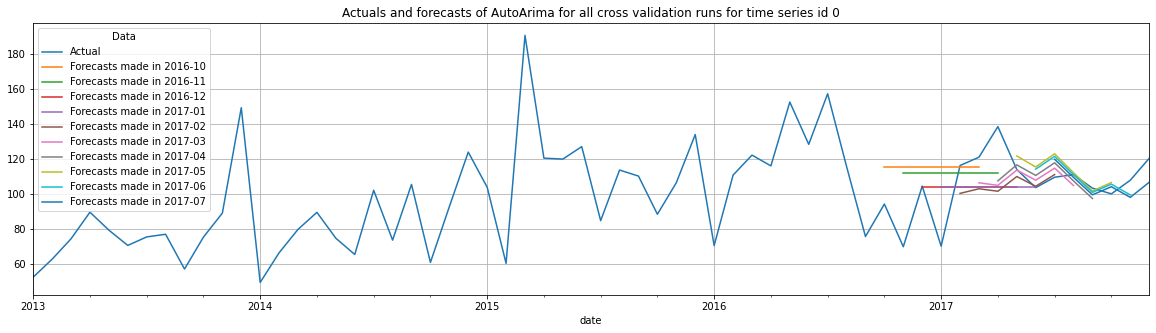

In [4]:
generate_plot(df_results_local1, data, 0, 'AutoArima')

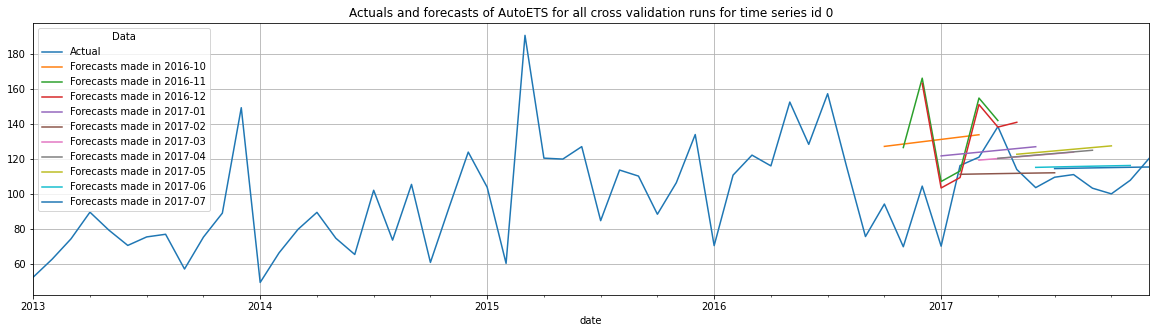

In [5]:
generate_plot(df_results_local1, data, 0, 'AutoETS')

## Temporal Fusion Transformer

In [6]:
#see https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

CV = 10 #number of CV runs, ie rolling time windows
results_tft = []
for cv in tqdm(range(CV-1,-1,-1)):    
    training_cutoff = data["time_idx"].max() - max_prediction_length - cv

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="volume",
        group_ids=["agency", "sku"],
        min_encoder_length=max_encoder_length // 2,  
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["agency", "sku"],
        static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
        time_varying_known_categoricals=["special_days", "month"],
        variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
        time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[
            "volume",
            "log_volume",
            "industry_volume",
            "soda_volume",
            "avg_max_temp",
            "avg_volume_by_agency",
            "avg_volume_by_sku",
        ],
        target_normalizer=GroupNormalizer(
            groups=["agency", "sku"], transformation="softplus"
        ), 
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = TimeSeriesDataSet.from_dataset(training, 
                                                data[lambda x: x.time_idx <= training_cutoff +
                                                     max_prediction_length], 
                                                predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 128  
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # configure network and trainer
    pl.seed_everything(42)
    trainer = pl.Trainer(
        gpus=0,
        gradient_clip_val=0.1,
    )

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    #Train model
    trainer = pl.Trainer(
        max_epochs=200,
        gpus=0,
        weights_summary="top",
        gradient_clip_val=0.1,
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,
        hidden_size=16,
        attention_head_size=1,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        #log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience=4,
    )

    # fit network
    trainer.fit(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    # calcualte mean absolute error on validation set
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_tft.predict(val_dataloader)

    column_names =  list(pd.Series(sorted(data.loc[data['time_idx'] > training_cutoff,
                              'date'].unique())).dt.to_period('M').dt.strftime('%Y-%m'))
    df_predictions = pd.DataFrame(predictions.numpy())
    df_predictions.columns = column_names[:max_prediction_length]
    df_predictions = df_predictions.stack().reset_index().rename(columns = {'level_0':'id', 'level_1':'date',0:'forecasts'})

    df_actuals = pd.DataFrame(actuals.numpy())
    df_actuals.columns = column_names[:max_prediction_length]
    df_actuals = df_actuals.stack().reset_index().rename(columns = {'level_0':'id', 'level_1':'date',0:'actuals'})

    df_result = df_predictions.merge(df_actuals, on = ['id', 'date'], how = 'left')
    df_result['CV'] = cv
    df_result['Model'] = 'Temporal Fusion Transformer'

    results_tft.append(df_result)
    
df_results_tft1 = pd.concat(results_tft)    

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\johan\.conda\envs\pytorch_forecasting\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 10%|████████▏                                                                         | 1/10 [02:54<26:06, 174.10s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 20%|████████████████▍                                                                 | 2/10 [04:46<18:21, 137.67s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 30%|████████████████████████▌                                                         | 3/10 [07:47<18:23, 157.66s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 40%|████████████████████████████████▊                                                 | 4/10 [10:19<15:30, 155.15s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 50%|█████████████████████████████████████████                                         | 5/10 [12:45<12:40, 152.02s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 60%|█████████████████████████████████████████████████▏                                | 6/10 [15:35<10:32, 158.12s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:59<07:41, 153.68s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:22<05:00, 150.05s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [23:17<02:37, 157.79s/it]

Global seed set to 42


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


GPU available: False, used: False


TPU available: False, using: 0 TPU cores



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:54<00:00, 157.62s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:54<00:00, 155.43s/it]

The plot shows actuals of time series with id 0 and forecasts by the Temporal Fusion Transformer. The forecasts  are generated by the 10-fold rolling window cross validation.

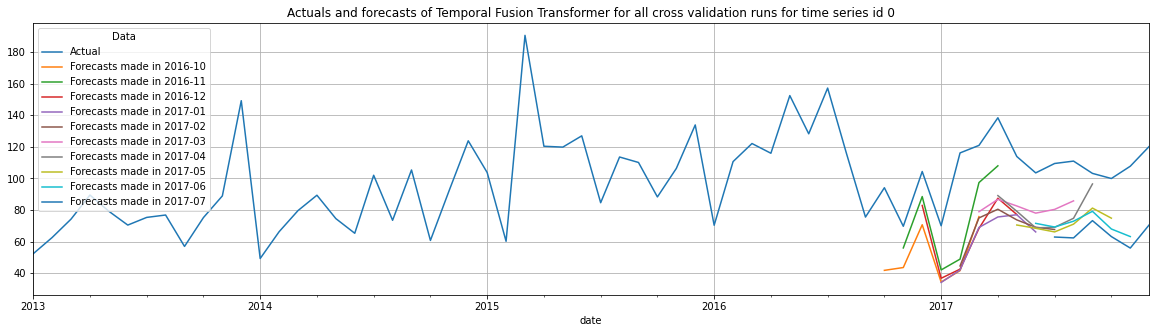

In [7]:
generate_plot(df_results_tft1.rename(columns = {'id':'timeseries_idx', 
                  'forecasts':'Forecast'}), data, 0, 'Temporal Fusion Transformer')

## N-beats: neural basis expansion analysis

In [8]:
CV = 10 #number of CV runs, ie rolling time windows
results_nbeats = []
for cv in tqdm(range(CV-1,-1,-1)):  
    training_cutoff = data["time_idx"].max() - max_prediction_length - cv

    context_length = max_encoder_length
    prediction_length = max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="volume",
        categorical_encoders={"timeseries": NaNLabelEncoder().fit(data.timeseries)},
        group_ids=["timeseries"],
        # only unknown variable is "value" 
        time_varying_unknown_reals=["volume"],
        max_encoder_length=context_length,
        max_prediction_length=prediction_length,
    )

    validation = TimeSeriesDataSet.from_dataset(training, 
                                        data[lambda x: x.time_idx <= training_cutoff +
                                             max_prediction_length], 
                                        predict=True, stop_randomization=True)
    batch_size = 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    trainer = pl.Trainer(
        max_epochs=200,
        gpus=0,
        weights_summary="top",
        gradient_clip_val=0.01,
        callbacks=[early_stop_callback],
        limit_train_batches=30,
    )

    net = NBeats.from_dataset(
        training,
        learning_rate=4e-2,#4e-3,
        log_interval=10,
        log_val_interval=1,
        weight_decay=1e-2,
        widths=[32, 512],
        backcast_loss_ratio=1.0,
    )

    trainer.fit(
        net,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = NBeats.load_from_checkpoint(best_model_path)


    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)


    column_names =  list(pd.Series(sorted(data.loc[data['time_idx'] > training_cutoff,
                          'date'].unique())).dt.to_period('M').dt.strftime('%Y-%m'))
    df_predictions = pd.DataFrame(predictions.numpy())
    df_predictions.columns = column_names[:max_prediction_length]
    df_predictions = df_predictions.stack().reset_index().rename(columns = {'level_0':'id', 'level_1':'date',0:'forecasts'})

    df_actuals = pd.DataFrame(actuals.numpy())
    df_actuals.columns = column_names[:max_prediction_length]
    df_actuals = df_actuals.stack().reset_index().rename(columns = {'level_0':'id', 'level_1':'date',0:'actuals'})

    df_result = df_predictions.merge(df_actuals, on = ['id', 'date'], how = 'left')
    df_result['CV'] = cv
    df_result['Model'] = 'Nbeats'

    results_nbeats.append(df_result)

df_results_nbeats1 = pd.concat(results_nbeats)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 10%|████████▎                                                                          | 1/10 [01:02<09:20, 62.23s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 20%|████████████████▌                                                                  | 2/10 [02:00<07:58, 59.86s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 30%|████████████████████████▉                                                          | 3/10 [03:44<09:21, 80.27s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [04:42<07:07, 71.29s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [06:21<06:46, 81.39s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [07:47<05:32, 83.00s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [10:00<04:57, 99.06s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [11:22<03:07, 93.66s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [12:25<01:24, 84.08s/it]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.530     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [14:12<00:00, 91.14s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [14:12<00:00, 85.21s/it]

The plot shows actuals of time series with id 0 and forecasts by the N-beats model. The forecasts  are generated by the 10-fold rolling window cross validation.

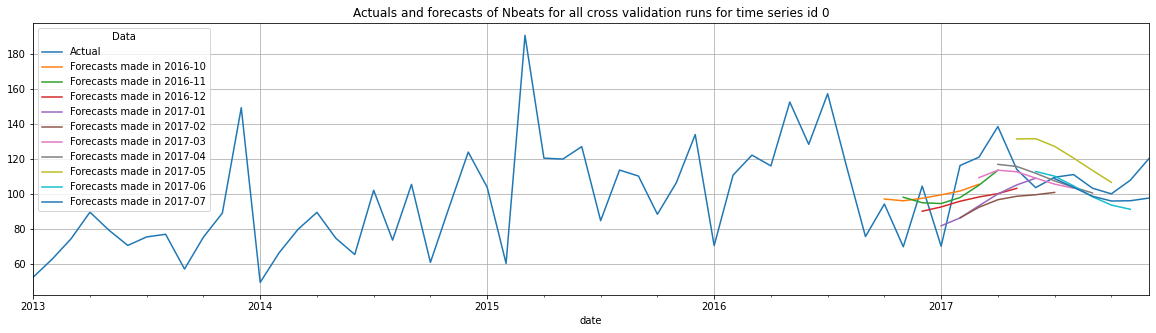

In [9]:
generate_plot(df_results_nbeats1.rename(columns = {'id':'timeseries_idx', 
                  'forecasts':'Forecast'}), data, 0, 'Nbeats')

## Results 


The table below reports 5 different metrics for the forecasts $f_{t+h|t}$ made at time $t$, $h$ periods ahead for the actual value $y_{t+h}$. The training data consists of $\{y_1, \ldots, y_t\}$. The dataset has $T = 60$ observations. The cross validation runs with 10 rolling windows are performed on a set of 

* 10 trainig datasets $\{ \{y_{1}, \ldots, y_{45}\}, \{y_{1}, \ldots, y_{46}\}, \ldots,  \{y_{1}, \ldots ,  y_{54}\}\}$ and
* 10 test datasets $\{ \{y_{46}, \ldots, y_{52}\}, \{y_{47}, \ldots, y_{53}\}, \ldots,  \{y_{55}, \ldots ,  y_{60}\}\}$. 

Note that the each of test data sets consists of 6 observations because the forecasting horizon $h \in \{1,2,3,4,5,6\}$, but the training data increases in size from crossvalidation run 1 to run 10.  

* The **Mean Absolute Error** (MAE) of all forecasts, i.e. 6 forecasts for each of the 10 cross validation runs: 
```{math}
\text{MAE} = \frac{1}{60}\sum_{c = 1}^{10}\sum_{h = 1}^6 |y_{44+c+h} - f_{44+c+h|44+c}|. 
```
* The **Mean Absolute Error** of all forecasts where  **actuals are larger than 0** (MAE$_{>0}$). I use this unusual metric because there are more than 50% of all actuals 0 and represents those cases separately. It is defined as: 
```{math}
\text{MAE}_{>0} = \frac{1}{60}\sum_{c = 1}^{10} \sum_{h = 1}^6 (\mathbb{1}_{y_{44+c+h}>0}) \times |y_{44+c+h} - f_{44+c+h|44+c}|. 
```
* The **Mean Absolute Percentage Error** (MAPE) of all forecasts, that is only defined for actuals larger than 0: 
```{math}
\text{MAPE} = \frac{1}{60}\sum_{c = 1}^{10}\sum_{h = 1}^6 \frac{|y_{44+c+h} - f_{44+c+h|44+c}|}{|y_{44+c+h}|}. 
```
* The **Median Absolute Percentage Error** is defined like the MAPE but instead of the mean the median of the errors is calcualted.  
* The **Mean Absolute Scaled Error** (MASE) follows the definition by [Hyndman](https://otexts.com/fpp2/accuracy.html#scaled-errors) for seasonal time series. For each cross validation run the absolute error of the seasonal naive model on the training data is used as a denominator. 
```{math}
\text{MASE} = \frac{1}{10}\sum_{c = 1}^{10} \frac{\sum_{h = 1}^6 |y_{44+c+h} - f_{44+c+h|44+c}|}{\frac{1}{44+c-12} \sum_{t = 12+1}^{44+c} |y_t - y_{t-12}|}. 
```


The results reported in the table below show that the neural network models are the only models that can beat the naive benchmark in all metrics. The Theta model performs worse than the benchmark except for the median absolute percentage error. 

For all models the mean absolute percentage errors are above 100%. The median percentage errors around 20%. This means that the data contain outlying errors. 

The table also reports the undefined MASE. This is caused by the fact that the data contains time series that have training data without any variance, i.e. actuals that are always zero. In these cases the MASE cannot be applied and this occurs for several training sets.

In [10]:
df_results_local1 =  df_results_local1.rename(columns= {'Forecast':'forecasts', 
                                  'volume':'actuals', 
                                  'timeseries_idx':'id'}).drop(columns =  'Replaced').copy()
df_results_local1['date'] = df_results_local1['date'].apply(lambda x: x.strftime('%Y-%m')) 

df_total1 = pd.concat([df_results_local1,    
                        df_results_tft1,
                        df_results_nbeats1])    


df_total1['AE'] = (df_total1['actuals']-df_total1['forecasts']).abs()
df_total1['PE'] = 100*(df_total1['actuals']-df_total1['forecasts']).abs()/(df_total1['actuals']).abs()


df_mae = df_total1.groupby(['Model'])['AE'].mean().reset_index(name = "Mean absolute error")

df_medape =df_total1[df_total1['actuals']>0].groupby(['Model'])['PE'].median().reset_index(
    name = "Median absolute percentage error")
    
df_mape =  df_total1[df_total1['actuals']>0].groupby(['Model'])['PE'].mean().reset_index(
    name = "Mean absolute percentage error")
    
df_mae0 = df_total1[df_total1['actuals']< 0.001].groupby(['Model'])['AE'].mean().reset_index(
    name = "Mean absolute error when actuals are 0")    

# Calculate MASE 

data_mase = data[['timeseries','volume','date']].sort_values(['timeseries','date']).copy()
data_mase['date'] = data_mase['date'].apply(lambda x: x.strftime('%Y-%m')) 
df_date_cv = df_total1.groupby(['CV'])['date'].min().reset_index().rename(columns = {'date':'min_date'})

df_mase_denominator_list = []
for cv in df_date_cv['CV'].unique():
    tmp = data_mase[data_mase['date'] < df_date_cv.loc[df_date_cv['CV'] == cv,'min_date'].squeeze() ].copy()
    #we choose the forecast horizon < than the seasonal period, therefore a simple shift is ok. 
    tmp['naive_forecast'] = tmp.groupby(['timeseries'])['volume'].shift(12)
    tmp = tmp[tmp['naive_forecast'].notna()]
    tmp['naive_forecast_AE'] = (tmp['naive_forecast']  - tmp['volume']).abs()
    df_mase_denominator = tmp.groupby(['timeseries'])['naive_forecast_AE'].mean().reset_index()
    df_mase_denominator = df_mase_denominator[df_mase_denominator['naive_forecast_AE'].notna()]
    df_mase_denominator['CV'] = cv
    df_mase_denominator_list.append(df_mase_denominator)
    
df_mase_denominator = pd.concat(df_mase_denominator_list)
df_mase_denominator = df_mase_denominator.rename(columns = {'timeseries':'id'})


df_mase = df_total1.merge(df_mase_denominator, on = ['id','CV'], how = 'left')
df_mase['MASE'] = df_mase['AE'] / df_mase['naive_forecast_AE']
df_mase = df_mase.groupby('Model')['MASE'].mean().reset_index()


pd.concat([df_mae, 
            df_medape.drop(columns = ['Model']), 
            df_mape.drop(columns = ['Model']),
            df_mae0.drop(columns = ['Model']),
            df_mase.drop(columns = ['Model'])] , axis = 1).round(2)

Model  Mean absolute error  \
0                    AutoArima               275.52   
1                      AutoETS               276.99   
2                       Nbeats               251.97   
3               Seasonal Naive               302.13   
4  Temporal Fusion Transformer               250.37   
5                        Theta               302.60   

   Median absolute percentage error  Mean absolute percentage error  \
0                             21.79                          185.10   
1                             21.11                          184.22   
2                             19.75                          134.99   
3                             26.59                          158.42   
4                             21.86                          119.53   
5                             23.28                          203.19   

   Mean absolute error when actuals are 0  MASE  
0                                    8.12   inf  
1                                   10.27   inf  
2                                    8.31   inf  
3                                    9.22   inf  
4                                    5.82   inf  
5                                    9.63   inf